# IQ Cloud Test (1Q + 2Q Multiplexed)

`iq_cloud` 실험/분석 모듈 사용 예제입니다.

목표:
- 1Q/2Q에서 `SINGLE_SHOT + INTEGRATION` 데이터 획득
- shared-covariance Gaussian + Bayes decision boundary 기반 분석
- fidelity / confusion matrix / separation / bootstrap CI 확인
        


In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260211-0052_2q_qst


# CONNECTION


In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.11 14:09:24.107] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 14:09:24.109] INFO    VERSION: laboneq 25.10.3
[2026.02.11 14:09:24.110] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 14:09:24.111] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 14:09:24.113] INFO    Configuring the device setup
[2026.02.11 14:09:24.115] INFO    The device setup is configured


In [3]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from experiments import iq_cloud


def unwrap_output(obj):
    cur = obj
    for _ in range(8):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def print_ci(name, ci_dict):
    print(
        f"{name}: mean={ci_dict['mean']:.4f}, std={ci_dict['std']:.4f}, "
        f"95% CI=[{ci_dict['ci_low']:.4f}, {ci_dict['ci_high']:.4f}]"
    )
        


In [4]:
# quick option check
exp_opts = iq_cloud.experiment_workflow.options()
exp_opts.do_analysis(True)
exp_opts.update(False)

ana_opts = iq_cloud.analysis_workflow.options()
ana_opts.do_plotting(True)
ana_opts.bootstrap_samples(2000)
print("iq_cloud options are ready")
        


iq_cloud options are ready


## 1Q Example


[2026.02.11 14:09:27.524] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 14:09:27.525] INFO      Workflow 'iq_cloud': execution started at 2026-02-11 05:09:27.524237Z         
[2026.02.11 14:09:27.525] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 14:09:27.540] INFO    Task 'temporary_qpu': started at 2026-02-11 05:09:27.540475Z
[2026.02.11 14:09:27.541] INFO    Task 'temporary_qpu': ended at 2026-02-11 05:09:27.541729Z
[2026.02.11 14:09:27.544] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 14:09:27.545] INFO    05:09:27.544756Z
[2026.02.11 14:09:27.545] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 05:09:27.545832Z
[2026.02.11 14:09:27.547] INFO    Task 'create_experiment': started at 2026-02-11 05:09:27.547165Z
[2026.02.11 14:09:27.554] INFO    Task 'create_experiment': ended at 2026-02-11 05:09:27.554221Z
[202

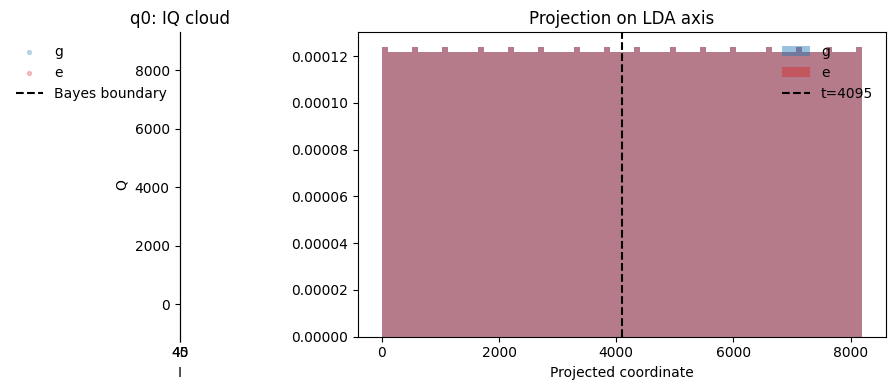

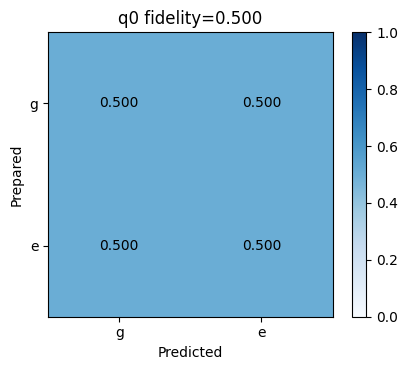

In [5]:
q0 = qubits[0]

opts_1q = iq_cloud.experiment_workflow.options()
opts_1q.do_analysis(True)
opts_1q.update(False)

wf_1q = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q0],
    options=opts_1q,
).run()

out_1q = unwrap_output(wf_1q)
analysis_1q = unwrap_output(out_1q["analysis_result"])

print("1Q assignment fidelity:", analysis_1q["assignment_fidelity"])
print("1Q separation:", analysis_1q["separation_metrics"])
print("1Q threshold:", analysis_1q["thresholds"][q0.uid])
        


In [ ]:
# 1Q bootstrap summary
bs_1q = analysis_1q["bootstrap"]["per_qubit"][q0.uid]
print_ci("1Q fidelity", bs_1q["fidelity"])
print_ci("1Q threshold", bs_1q["threshold"])
print_ci("1Q delta_mu_over_sigma", bs_1q["delta_mu_over_sigma"])
print_ci("1Q mahalanobis_distance", bs_1q["mahalanobis_distance"])
        


## 2Q Multiplexed Example


In [ ]:
q0, q1 = qubits[0], qubits[1]

opts_2q = iq_cloud.experiment_workflow.options()
opts_2q.do_analysis(True)
opts_2q.update(False)

wf_2q = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q0, q1],
    options=opts_2q,
).run()

out_2q = unwrap_output(wf_2q)
analysis_2q = unwrap_output(out_2q["analysis_result"])

print("2Q assignment fidelity:")
print(analysis_2q["assignment_fidelity"])
print()
print("2Q separation:")
print(analysis_2q["separation_metrics"])


In [ ]:
# 2Q bootstrap summary
bs_2q = analysis_2q["bootstrap"]

for uid in [q0.uid, q1.uid]:
    print()
    print(f"[{uid}] bootstrap")
    print_ci("fidelity", bs_2q["per_qubit"][uid]["fidelity"])
    print_ci("threshold", bs_2q["per_qubit"][uid]["threshold"])
    print_ci("delta_mu_over_sigma", bs_2q["per_qubit"][uid]["delta_mu_over_sigma"])
    print_ci("mahalanobis_distance", bs_2q["per_qubit"][uid]["mahalanobis_distance"])

print()
print("[joint]", bs_2q["joint"]["fidelity"])
print("[average]", bs_2q["average"]["fidelity"])


In [ ]:
# Plot confusion matrices (counts + normalized)
cm = analysis_2q["confusion_matrices"]

fig, axes = plt.subplots(2, 3, figsize=(13, 7))

uids = [q0.uid, q1.uid]
for i, uid in enumerate(uids):
    c_counts = np.array(cm["per_qubit"][uid]["counts"], dtype=float)
    c_norm = np.array(cm["per_qubit"][uid]["normalized"], dtype=float)

    im0 = axes[0, i].imshow(c_counts, cmap="Blues")
    axes[0, i].set_title(f"{uid} counts")
    axes[0, i].set_xticks([0, 1], ["g", "e"])
    axes[0, i].set_yticks([0, 1], ["g", "e"])
    for r in range(2):
        for c in range(2):
            axes[0, i].text(c, r, f"{c_counts[r,c]:.0f}", ha="center", va="center")
    plt.colorbar(im0, ax=axes[0, i], fraction=0.046)

    im1 = axes[1, i].imshow(c_norm, vmin=0, vmax=1, cmap="Reds")
    axes[1, i].set_title(f"{uid} normalized")
    axes[1, i].set_xticks([0, 1], ["g", "e"])
    axes[1, i].set_yticks([0, 1], ["g", "e"])
    for r in range(2):
        for c in range(2):
            axes[1, i].text(c, r, f"{c_norm[r,c]:.3f}", ha="center", va="center")
    plt.colorbar(im1, ax=axes[1, i], fraction=0.046)

joint_counts = np.array(cm["joint"]["counts"], dtype=float)
joint_norm = np.array(cm["joint"]["normalized"], dtype=float)
labels = cm["joint"]["labels"]

im2 = axes[0, 2].imshow(joint_counts, cmap="Blues")
axes[0, 2].set_title("joint counts")
axes[0, 2].set_xticks(range(4), labels)
axes[0, 2].set_yticks(range(4), labels)
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

im3 = axes[1, 2].imshow(joint_norm, vmin=0, vmax=1, cmap="Reds")
axes[1, 2].set_title("joint normalized")
axes[1, 2].set_xticks(range(4), labels)
axes[1, 2].set_yticks(range(4), labels)
for r in range(4):
    for c in range(4):
        axes[1, 2].text(c, r, f"{joint_norm[r,c]:.3f}", ha="center", va="center", fontsize=8)
plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)

plt.tight_layout()
plt.show()
        


## Optional: Apply Threshold Update to QPU

아래 셀은 분석으로 얻은 threshold를 `qpu` 파라미터에 반영합니다.
        


In [ ]:
opts_update = iq_cloud.experiment_workflow.options()
opts_update.do_analysis(True)
opts_update.update(True)

_ = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q0, q1],
    options=opts_update,
).run()

print(qpu[q0.uid].parameters.readout_integration_discrimination_thresholds)
print(qpu[q1.uid].parameters.readout_integration_discrimination_thresholds)
        
